# Radar-adjustement for OpenMRG dataset

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))

sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1. Load and explore the data

In [5]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'}).load()
ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


In [3]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

### Plot raw time series

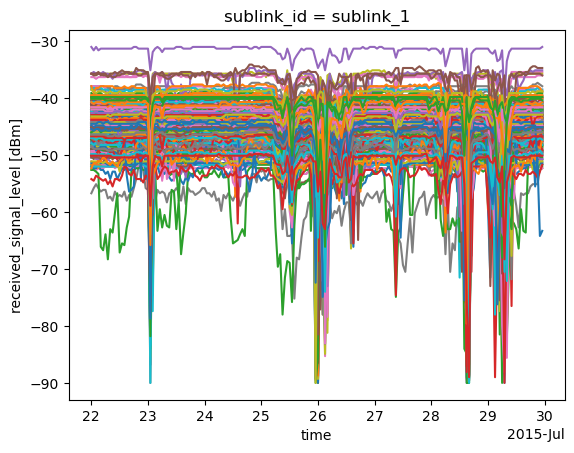

In [4]:
ds_cmls.rsl.isel(sublink_id=0).resample(time='1h').min().plot.line(x='time', add_legend=False);

Text(0.5, 1.0, 'Rain gauges')

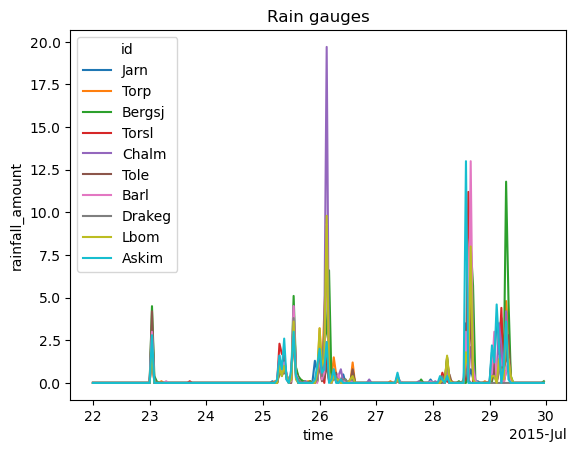

In [5]:
ds_gauges_municp.rainfall_amount.resample(time='1h').sum().plot.line(x='time');
plt.title('Rain gauges')

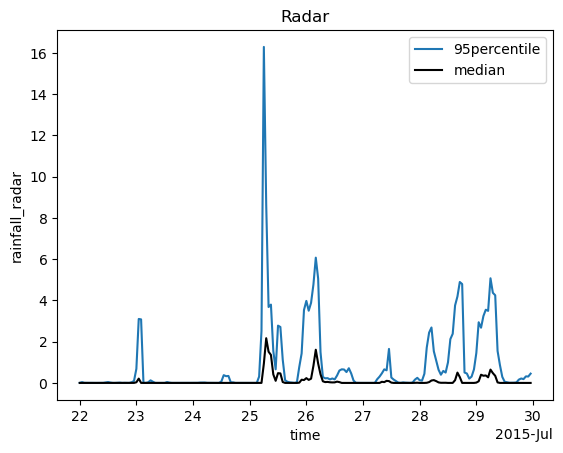

In [6]:
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.95, dim=['x', 'y']).plot(color = 'C0', label='95percentile');
ds_rad.rainfall_radar.resample(time='1h').mean().quantile(q = 0.5, dim=['x', 'y']).plot(color = 'k', label='median');
plt.title('Radar')
plt.legend()

### CML preprocessing 

In [7]:
# Select time window for preprocessing
start = ds_cmls.time[0]
end = ds_cmls.time[-1]
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() # load() speeds up calculations

# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

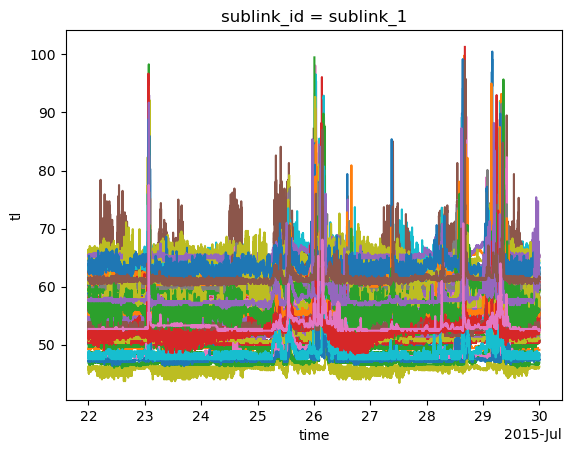

In [8]:
# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1
ds_cmls.where(qc_diurnalcicle, drop=True).tl.plot.line(x='time', add_legend=False);

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_diurnalcicle, drop=True)

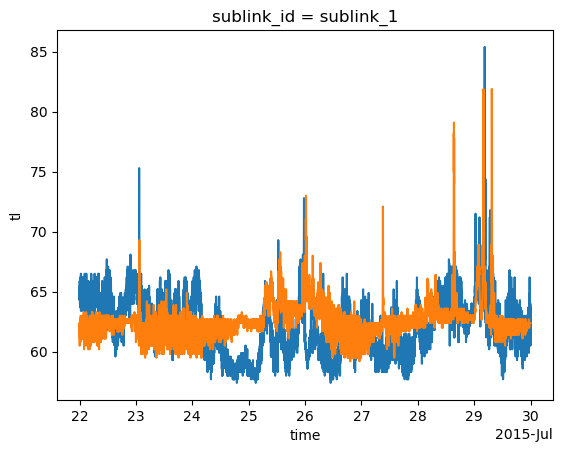

In [9]:
# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

# Plot noisy CMLs
ds_cmls.where(qc_noisyperiods, drop=True).tl.plot.line(x='time', add_legend=False);

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_noisyperiods, drop=True)

### CML processing using radar wet

In [11]:
# Estimate radar along CML
grid_at_lines = plg.spatial.GridAtLines(ds_rad, ds_cmls)

# Radar rainfall rates along CML
da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

# Resample to sum 1 minute to make comparable to CML
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

In [12]:
# Estimate the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)

### Resample units of reference data to common 15 minute resolution

In [13]:
time_resample = '60min'
ds_rad_resampled = (ds_rad[['rainfall_radar']]*5/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min
ds_gauges_resampled = ds_gauges_municp[['rainfall_amount']].resample(time=time_resample, label='right', closed='right').sum() # from sum 1min -> sum 15min 
ds_cmls_resampled = (ds_cmls[['R']]/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min

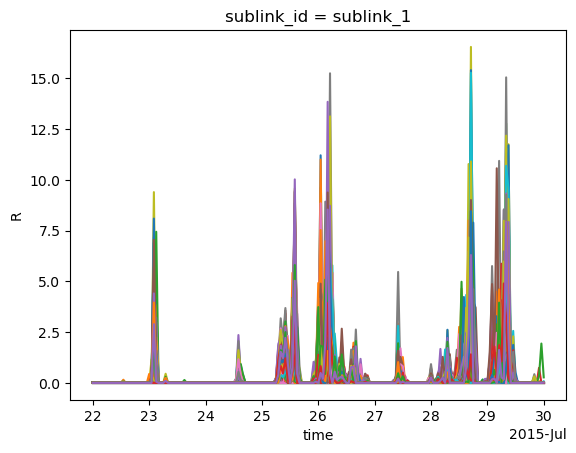

In [14]:
ds_cmls_resampled.R.plot.line(x='time', add_legend=False);

### Interpolate CMLs all time steps

In [105]:
# Import interpolator
interpolator = mrg.interpolate.InterpolateIDW()

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        interpolator.interpolate(
            da_grid = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            p=2, # IDW parameter
            nnear=8, # IDW number of nearest observations to use
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_interpolateIDW'] = xr.concat(rainfall_field, dim="time")

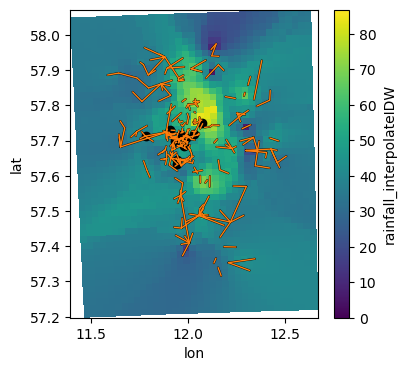

In [106]:
# Plot map
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plg.plot_map.plot_plg(
    da_grid=ds_rad_resampled['rainfall_interpolateIDW'].sum(dim='time'),
    #da_gauges=da_gauges_municp_15min.isel(time = t),
    #da_cmls=da_cmls_15min.isel(time = 0),
    use_lon_lat=True,
    vmin=0,
    marker_size=100,
    cmap='viridis',
    ax=ax
)

# Plot CMLs
plg.plot_map.plot_lines(ds_cmls_resampled.isel(time = 0), use_lon_lat=True, ax=ax, line_color= 'C1');

# PLot rain gauges
ax.scatter(ds_gauges_resampled.lon, ds_gauges_resampled.lat, color='k')

### Exercises
1. Plot accumulated rainfall map for radar (same as done for IDW interpolation in the cell above).
2. Compare the accumulated radar rainfall map with the accumulated CML IDW interpolated rainfall map. How do they differ?


# 2. Evaluate rainfall maps at rain gauges
In this example we will study how well the radar and the CMLs predict the rain gauge observations

### Evaluate radar rainfall field at rain gauge

In [107]:
get_grid_at_points = plg.spatial.GridAtPoints(
    ds_rad_resampled, 
    ds_gauges_resampled, 
    nnear=1,
    stat="best",
)

ds_gauges_resampled['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_radar,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)


### Plot time series of one rain gauge and weather radar

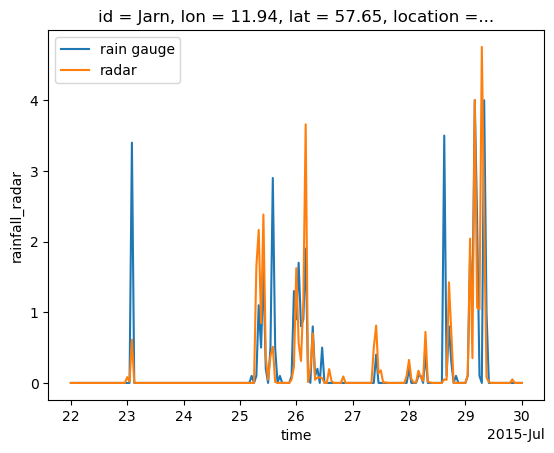

In [108]:
ds_gauges_resampled.rainfall_amount.isel(id = 0).plot(label='rain gauge')
ds_gauges_resampled.rainfall_radar.isel(id = 0).plot(label='radar')
plt.legend()

### Scatter-density plot radar VS rain gauge

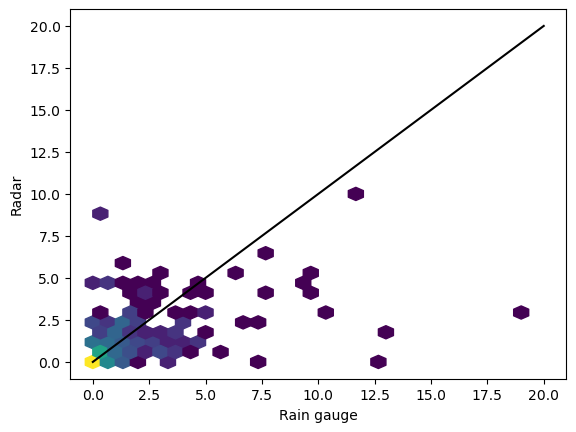

In [109]:
xmax = 20
plt.hexbin(
    ds_gauges_resampled.rainfall_amount,
    ds_gauges_resampled.rainfall_radar,
    bins='log',
    gridsize=30,
    extent = [0, xmax, 0, xmax],
)
plt.plot([0, xmax], [0, xmax], 'k');
plt.xlabel('Rain gauge');
plt.ylabel('Radar');

### Exercises
1. Evaluate CML IDW interpolated field at rain gauges and plot a hexbin (as above). How do the radar and IDW interpolated CML maps differ?

# 3. Merge CML and radar data for 8 days

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../poligrain/src"))
sys.path.append(os.path.abspath("../mergeplg/src"))

sys.path.append(os.path.abspath("../pycomlink/"))


import poligrain as plg
import mergeplg as mrg
import pycomlink as pycml
import tqdm

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Fetches 8 days from OpenMRG dataset
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

ds_cmls = ds_cmls.rename_vars({'R': 'R_example'}).load()
ds_rad = ds_rad.rename({'R':'rainfall_radar'})

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


### Project coordinates

In [4]:
# Project data to coordinate system
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

ds_gauges_municp.coords["x"], ds_gauges_municp.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges_municp.lon, ds_gauges_municp.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2


# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

### Pre-process CML data

In [5]:
# Select time window for preprocessing
start = ds_cmls.time[0]
end = ds_cmls.time[-1]
ds_cmls = ds_cmls.sel(time = slice(start, end)).load() # load() speeds up calculations

# Select sublink 0
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Resample CML dataset to 1 minute resolution
ds_cmls = ds_cmls.resample(time = "1min").first(skipna=True)

# calculate total loss
ds_cmls["tl"] = ds_cmls.tsl - ds_cmls.rsl

# Interpolate na
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# flag cmls with strong diurnal fluctuation
qc_diurnalcicle = (ds_cmls.tl.rolling(time=60 * 5, center=True).std() > 2).mean(dim="time") > 0.1

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_diurnalcicle, drop=True)

# flag cmls with very noisy periods
qc_noisyperiods = (ds_cmls.tl.rolling(time=60, center=True).std() > 0.8).mean(dim="time") > 0.20

# Remove flagged CMLs
ds_cmls = ds_cmls.where(~qc_noisyperiods, drop=True)

### Process CML data

In [6]:
# Estimate radar along CML
grid_at_lines = plg.spatial.GridAtLines(ds_rad, ds_cmls)

# Radar rainfall rates along CML
da_radar_along_cmls = grid_at_lines(ds_rad.rainfall_radar)

# Set wet periods above threshold
ds_cmls['wet'] = (da_radar_along_cmls > 0.1).rolling(time=3, center=True).max()

# Estimate the baseline during rain events
ds_cmls["baseline"] = pycml.processing.baseline.baseline_constant(
    trsl=ds_cmls.tl,
    wet=ds_cmls.wet,
    n_average_last_dry=5,
)

# compenmsate for wet antenna attenuation
ds_cmls["A_obs"] = ds_cmls.tl - ds_cmls.baseline
ds_cmls["A_obs"] = ds_cmls.A_obs.where(ds_cmls.A_obs >= 0, 0)
ds_cmls["waa"] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=ds_cmls.A_obs,
    f_Hz=ds_cmls.frequency * 1e6,
    pol=ds_cmls.polarization.data,
    L_km=ds_cmls.length / 1000,
    A_max=6,
    zeta=0.7,  # 0.55 is default
    d=0.15, # 
)


# calculate attenuation caused by rain and remove negative attenuation
ds_cmls["A"] = ds_cmls.tl - ds_cmls.baseline - ds_cmls.waa
ds_cmls["A"].data[ds_cmls.A < 0] = 0
# derive rain rate via the k-R relation
ds_cmls["R"] = pycml.processing.k_R_relation.calc_R_from_A(
    A=ds_cmls.A,
    L_km=ds_cmls.length.astype(float) / 1000,  # convert to km
    f_GHz=ds_cmls.frequency / 1000,  # convert to GHz
    pol=ds_cmls.polarization,
)

### Resample data to common time resolution

In [7]:
time_resample = '60min'
ds_rad_resampled = (ds_rad[['rainfall_radar']]*5/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min
ds_gauges_resampled = ds_gauges_municp[['rainfall_amount']].resample(time=time_resample, label='right', closed='right').sum() # from sum 1min -> sum 15min 
ds_cmls_resampled = (ds_cmls[['R']]/60).resample(time = time_resample, label='right', closed='right').sum() # from mm/h -> sum 5min


### Merge IDW and kriging for all time steps

In [22]:
# Import interpolator
merger = mrg.merge.MergeDifferenceIDW(min_observations=1)

# Interpolate several timesteps
rainfall_field = []
for time in ds_cmls_resampled.time.data:
    rainfall_field.append(
        merger.adjust(
            da_rad = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            p=2, # IDW parameter
            nnear=12, # number of nearest observations to use
            method='additive',
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_additiveIDW'] = xr.concat(rainfall_field, dim="time")

### Plot rainfall maps for some time steps

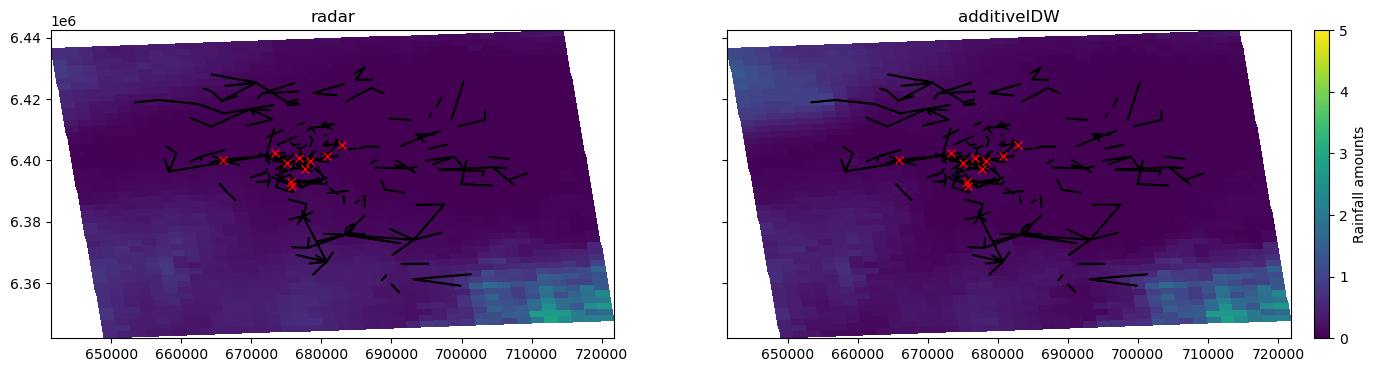

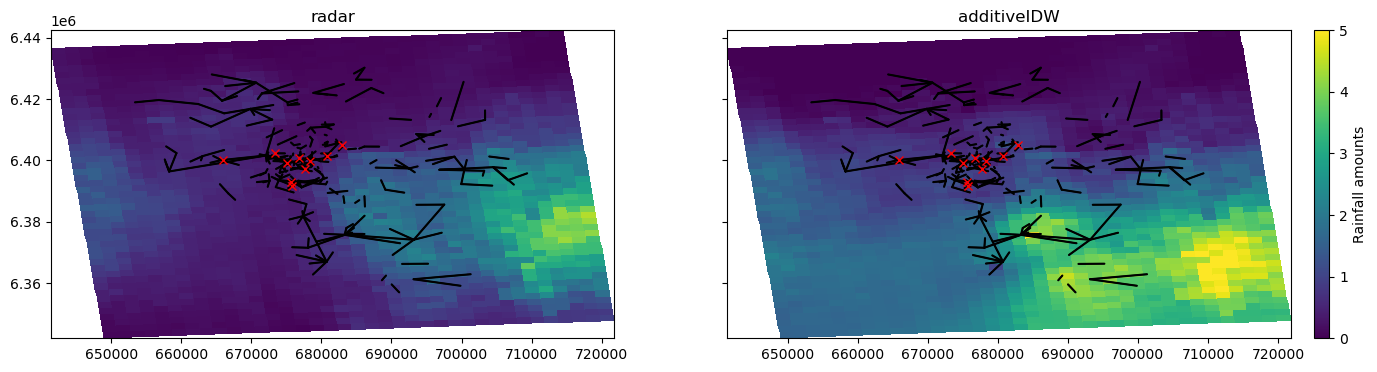

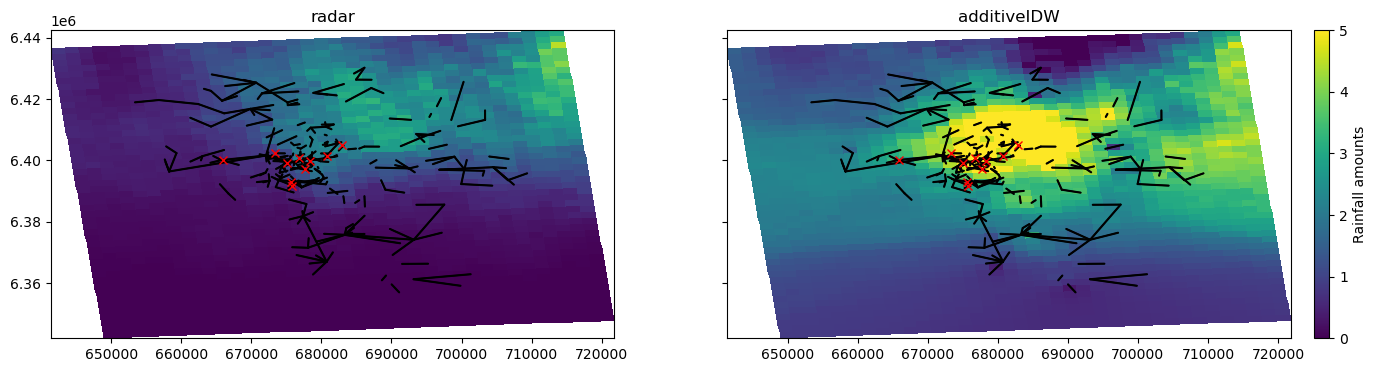

In [26]:
vmax = 5  # max color
cmap_rain = "viridis"
# Time interval to plot
time_start = "2015-07-25T12"
time_end = "2015-07-25T15"

# Rainfall fields to plot
rainfall_fields = [
    "rainfall_radar",
    "rainfall_additiveIDW",
]

for time in ds_rad_resampled.sel(time=slice(time_start, time_end)).time[:3]:
    fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(20, 4), sharey=True)
    for i, rainfall_field in enumerate(rainfall_fields):
        # Plot rainfall field
        im = ax[i].pcolormesh(
            ds_rad_resampled.x_grid,
            ds_rad_resampled.y_grid,
            ds_rad_resampled[rainfall_field].sel(time=time),
            vmin=0,
            vmax=vmax,
            cmap=cmap_rain,
        )

        # Plot postion CMLs
        plg.plot_map.plot_lines(
            ds_cmls_resampled,
            use_lon_lat=False,
            ax=ax[i],
            line_color="k",
        )

        ax[i].set_title(rainfall_field.split("_")[1])
        ax[i].plot(ds_gauges_resampled.x, ds_gauges_resampled.y, 'xr')

    clb = fig.colorbar(im, ax=ax, location="right", anchor=(-0.25, 1.0))
    clb.ax.set_ylabel("Rainfall amounts")
    plt.show()

### Evalute rainfall fields at rain gauge positions

In [27]:
get_grid_at_points = plg.spatial.GridAtPoints(
    ds_rad_resampled, 
    ds_gauges_resampled, 
    nnear=1,
    stat="best",
)

ds_gauges_resampled['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_radar,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

ds_gauges_resampled['rainfall_additiveIDW'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_additiveIDW,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

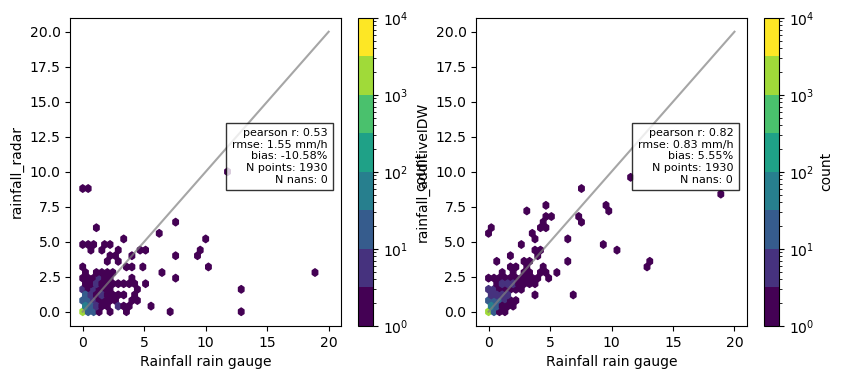

In [28]:
xmax = 20

# What fields to consider
rainfall_fields = [
    "rainfall_radar",
    "rainfall_additiveIDW",
]

fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(4*len(rainfall_fields)*1.2, 4))
for i, rainfall_field in enumerate(rainfall_fields):
    estimate = ds_gauges_resampled[rainfall_field].data.ravel()
    reference = ds_gauges_resampled.rainfall_amount.data.ravel()
        
    # Plot hexbin
    plg.validation.plot_hexbin(reference, estimate, ax=ax[i])
    
    threshold = 0.01 # values below are ignored
    rainfall_metrics = plg.validation.calculate_rainfall_metrics(
        reference=reference,
        estimate=estimate,
        ref_thresh=threshold,
        est_thresh=threshold,
    )
    plotted_metrics = (
        f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
        f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
        f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
        f"N points: {rainfall_metrics['N_all']}\n"
        f"N nans: {rainfall_metrics['N_nan']}"
    )
    
    ax[i].text(
        0.95,
        0.55,
        plotted_metrics,
        fontsize=8,
        transform=ax[i].transAxes,
        verticalalignment="center",
        horizontalalignment="right",
        bbox={"facecolor": "white", "alpha": 0.8},
    )
    ax[i].set_ylabel(str(rainfall_field))
    ax[i].set_xlabel('Rainfall rain gauge')


### Exercises

1. Perform additive block kriging interpolation (OBK) of the data. Plot 3 time steps comparing radar, IDW and OBK maps. Hint: See code above for map and hexbin. Code below for block kriging.
2. Perform hexbinplots comparing the radar, IDW and OKB maps. Hint: Use the OBK maps you just created and use the code above to create a hexbin plot.
3. Test different kriging parameters, is there any parameters that works better? How does the range and nugget affect the resulting field. 
4. Experiment with multiplicative adjustment. Hint: Set "method = 'multiplicative', in the OBK code. 

In [89]:
# Import interpolator
merger = mrg.merge.MergeDifferenceOrdinaryKriging(min_observations=1)

# Interpolate several timesteps
rainfall_field = []
for time in tqdm.tqdm(ds_cmls_resampled.time.data):
    rainfall_field.append(
        merger.adjust(
            da_rad = ds_rad_resampled.rainfall_radar.sel(time = [time]), 
            #da_gauge = da_gauge_smhi_15min.sel(time = [time]), 
            da_cml = ds_cmls_resampled.R.sel(time = [time]),
            variogram_model = "spherical",
            variogram_parameters = {"sill": 1, "range": 8000, "nugget": 0.2},
            nnear=12,
            full_line=True, #
            method='additive'
        )
    )

# Concat resulting fields
ds_rad_resampled['rainfall_adjustOBK'] = xr.concat(rainfall_field, dim="time")


100%|█| 193/193 [01:33<00:00,  2.07i


In [90]:
ds_gauges_resampled['rainfall_adjustOBK'] = get_grid_at_points(
    da_gridded_data=ds_rad_resampled.rainfall_adjustOBK,
    da_point_data=ds_gauges_resampled.rainfall_amount,
)

Text(0.95, 0.55, 'pearson r: 0.83\nrmse: 0.82 mm/h\nbias: 2.65%\nN points: 1930\nN nans: 0')

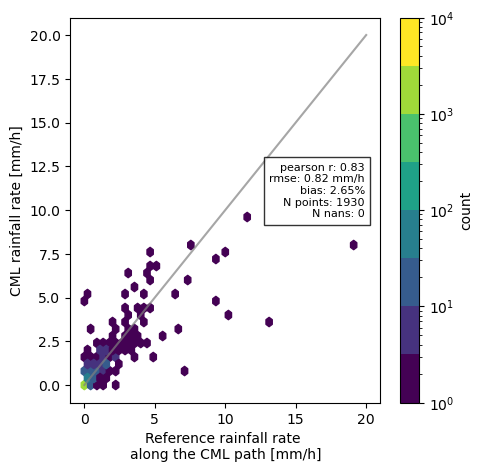

In [91]:
xmax = 20
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
reference = ds_gauges_resampled.rainfall_amount.data.ravel()
estimate = ds_gauges_resampled.rainfall_adjustOBK.data.ravel()

# Plot hexbin
plg.validation.plot_hexbin(reference, estimate, ax=ax)

threshold = 0.01 # values below are ignored
rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=reference,
    estimate=estimate,
    ref_thresh=threshold,
    est_thresh=threshold,
)
plotted_metrics = (
    f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
    f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
    f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
    f"N points: {rainfall_metrics['N_all']}\n"
    f"N nans: {rainfall_metrics['N_nan']}"
)

ax.text(
    0.95,
    0.55,
    plotted_metrics,
    fontsize=8,
    transform=ax.transAxes,
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "white", "alpha": 0.8},
)


# Extra exercises
2. Perform interpolation (IDW, OK, OBK) and radar adjustement to CML (IDW, OK, OBK). Compare resulting fields to rain gauges. What method performs best?
3. ds_gauges_municp contains data for a rain gauge operated by SMHI. Perform IDW interpolation and IDW adjustment of rain gauge data (from municipality) and compare the resulting rainfall fields to ds_gauges_municp.
4. Experiment with differnet CML processing parameters. How does this affect the final fields?